In [11]:
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
# utils
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix


In [4]:
import torch
from glob import glob
import os
import random
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"  # Update this to your dataset root
image_size = (224, 224)

# Data augmentation for training, resizing for validation and testing
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get all image paths and corresponding labels
image_paths = []
labels = []
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):  # Check if it is a folder
        class_images = glob(os.path.join(class_folder, "*.jpg"))
        image_paths.extend(class_images)
        labels.extend([class_name] * len(class_images))  # Use folder name as label

# Shuffle the dataset
data = list(zip(image_paths, labels))
random.shuffle(data)
image_paths, labels = zip(*data)

# Encode labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
labels = [label_to_index[label] for label in labels]

# Split into train, validation, and test sets
train_ratio = 0.7  # 70% training
val_ratio = 0.15  # 15% validation
test_ratio = 0.15  # 15% testing

train_size = int(train_ratio * len(image_paths))
val_size = int(val_ratio * len(image_paths))
test_size = len(image_paths) - train_size - val_size

train_paths = image_paths[:train_size]
train_labels = labels[:train_size]

val_paths = image_paths[train_size:train_size + val_size]
val_labels = labels[train_size:train_size + val_size]

test_paths = image_paths[train_size + val_size:]
test_labels = labels[train_size + val_size:]

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.image_paths)

# Create datasets
train_dataset = CustomDataset(train_paths, train_labels, transform=train_transform)
val_dataset = CustomDataset(val_paths, val_labels, transform=test_transform)
test_dataset = CustomDataset(test_paths, test_labels, transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check device and dataset sizes
print(f"Device: {device}")
print(f"Total images: {len(image_paths)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

# Example to check a batch
for images, labels in train_loader:
    print(f"Batch of images: {images.size()}")
    print(f"Batch of labels: {labels}")
    break


Device: cuda
Total images: 12446
Training set size: 8712
Validation set size: 1866
Testing set size: 1868
Batch of images: torch.Size([32, 3, 224, 224])
Batch of labels: tensor([1, 0, 1, 1, 0, 0, 3, 1, 3, 2, 0, 3, 1, 2, 0, 3, 3, 1, 2, 1, 1, 3, 1, 1,
        0, 2, 1, 1, 2, 2, 1, 1])


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1,   Train Loss: 0.3192, Train Accuracy: 88.98%
Eval Loss: 0.1677, Eval Accuracy: 94.00%
######################################################################
Epoch 2,   Train Loss: 0.1196, Train Accuracy: 96.21%
Eval Loss: 0.1129, Eval Accuracy: 96.57%
######################################################################
Epoch 3,   Train Loss: 0.0940, Train Accuracy: 96.95%
Eval Loss: 0.1274, Eval Accuracy: 96.46%
######################################################################
Epoch 4,   Train Loss: 0.0572, Train Accuracy: 98.34%
Eval Loss: 0.0295, Eval Accuracy: 99.20%
######################################################################
Epoch 5,   Train Loss: 0.0590, Train Accuracy: 98.13%
Eval Loss: 0.0678, Eval Accuracy: 97.32%
######################################################################
Epoch 6,   Train Loss: 0.0616, Train Accuracy: 98.06%
Eval Loss: 0.0605, Eval Accuracy: 98.29%
######################################################################
Epoc

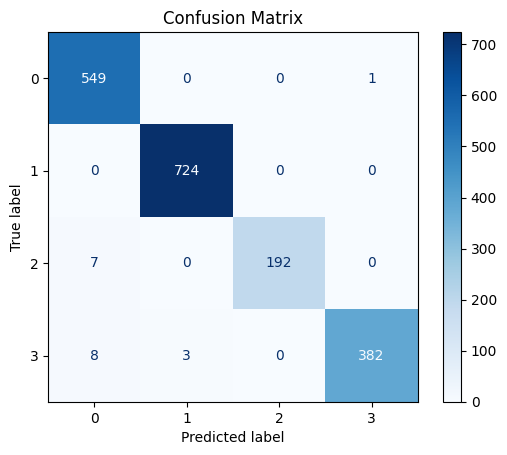

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       550
           1       1.00      1.00      1.00       724
           2       1.00      0.96      0.98       199
           3       1.00      0.97      0.98       393

    accuracy                           0.99      1866
   macro avg       0.99      0.98      0.99      1866
weighted avg       0.99      0.99      0.99      1866



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import ViTForImageClassification

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the ViT model
num_classes = 4  # Replace with the number of classes in your dataset
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes
).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# Initialize lists for tracking training/validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_score = float("inf")
n_epochs = 10
tolerance = 0

# Training and evaluation functions
def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(data).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)
        
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def eval_model():
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            
            outputs = model(data).logits
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)
            
    avg_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def get_predictions_and_labels():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data).logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Training loop
for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"vit_model_{epoch + 1}.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)

# Generate predictions and true labels
preds, true_labels = get_predictions_and_labels()
# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, preds))


# CNN

In [8]:
class MyModel(nn.Module):
    def __init__(self,num_classes):
        super(MyModel,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        
        
        
        
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = MyModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0002)


Epoch 0,   Train Loss: 0.5008, Train Accuracy: 80.26%
Eval Loss: 0.3044, Eval Accuracy: 87.51%
######################################################################
Epoch 1,   Train Loss: 0.1885, Train Accuracy: 93.08%
Eval Loss: 0.1984, Eval Accuracy: 92.93%
######################################################################
Epoch 2,   Train Loss: 0.1203, Train Accuracy: 95.67%
Eval Loss: 0.0791, Eval Accuracy: 97.43%
######################################################################
Epoch 3,   Train Loss: 0.0820, Train Accuracy: 97.21%
Eval Loss: 0.2335, Eval Accuracy: 92.28%
######################################################################
Epoch 4,   Train Loss: 0.0617, Train Accuracy: 97.91%
Eval Loss: 0.0513, Eval Accuracy: 98.07%
######################################################################
Epoch 5,   Train Loss: 0.0584, Train Accuracy: 98.07%
Eval Loss: 0.0225, Eval Accuracy: 99.36%
######################################################################
Epoc

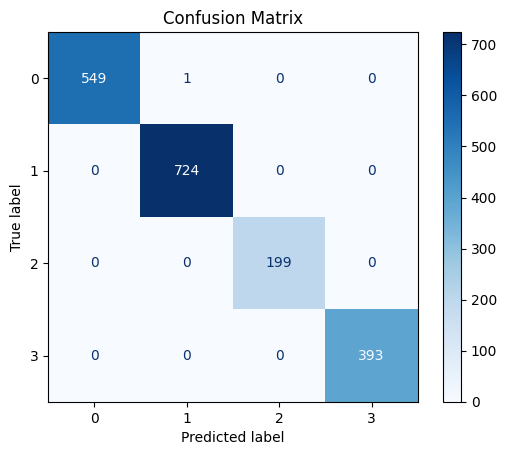

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       550
           1       1.00      1.00      1.00       724
           2       1.00      1.00      1.00       199
           3       1.00      1.00      1.00       393

    accuracy                           1.00      1866
   macro avg       1.00      1.00      1.00      1866
weighted avg       1.00      1.00      1.00      1866



In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Assuming these lists are defined somewhere in your code
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


best_score = float("inf")
n_epochs = 10
tolerance = 0

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)
        
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def eval_model():
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)
            
    avg_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def get_predictions_and_labels():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)  # Adjust based on the number of items your DataLoader returns
            labels = batch[1].to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)

# Generate predictions and true labels
preds, true_labels = get_predictions_and_labels()
# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Print classification report
print("Classification Report:")
print(classification_report(true_labels, preds))


# Densenet 

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 217MB/s]


Epoch 1: Train Loss: 0.1585, Train Acc: 94.67%, Val Loss: 0.0306, Val Acc: 99.09%
Epoch 2: Train Loss: 0.0395, Train Acc: 98.85%, Val Loss: 0.0139, Val Acc: 99.68%
Epoch 3: Train Loss: 0.0187, Train Acc: 99.47%, Val Loss: 0.0100, Val Acc: 99.84%
Epoch 4: Train Loss: 0.0192, Train Acc: 99.55%, Val Loss: 0.0031, Val Acc: 100.00%
Epoch 5: Train Loss: 0.0185, Train Acc: 99.36%, Val Loss: 0.0146, Val Acc: 99.68%
Epoch 6: Train Loss: 0.0084, Train Acc: 99.76%, Val Loss: 0.0010, Val Acc: 100.00%
Epoch 7: Train Loss: 0.0101, Train Acc: 99.69%, Val Loss: 0.0190, Val Acc: 99.41%
Epoch 8: Train Loss: 0.0180, Train Acc: 99.40%, Val Loss: 0.0189, Val Acc: 99.52%
Epoch 9: Train Loss: 0.0214, Train Acc: 99.35%, Val Loss: 0.0046, Val Acc: 99.89%
Epoch 10: Train Loss: 0.0027, Train Acc: 99.94%, Val Loss: 0.0047, Val Acc: 99.84%


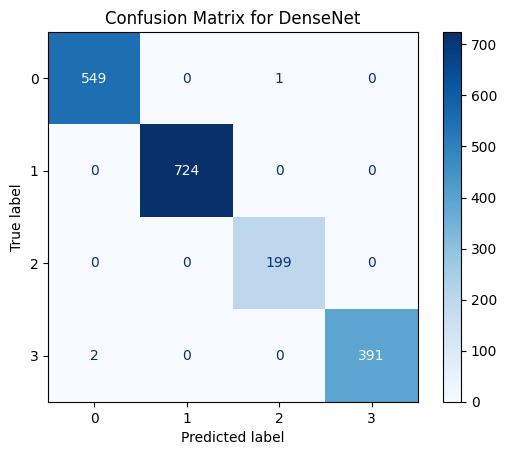

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       550
           1       1.00      1.00      1.00       724
           2       0.99      1.00      1.00       199
           3       1.00      0.99      1.00       393

    accuracy                           1.00      1866
   macro avg       1.00      1.00      1.00      1866
weighted avg       1.00      1.00      1.00      1866



In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Model definition
class DenseNetModel(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetModel, self).__init__()
        self.densenet = models.densenet121(pretrained=True)  # Using DenseNet-121
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, num_classes)  # Replace classifier with custom output layer

    def forward(self, x):
        return self.densenet(x)

# Initialize the model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNetModel(num_classes=4).to(device)  # Set num_classes appropriately
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

def eval_model(loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# Main training loop
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model(val_loader)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "densenet.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# Generate predictions and true labels
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for DenseNet")
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds))


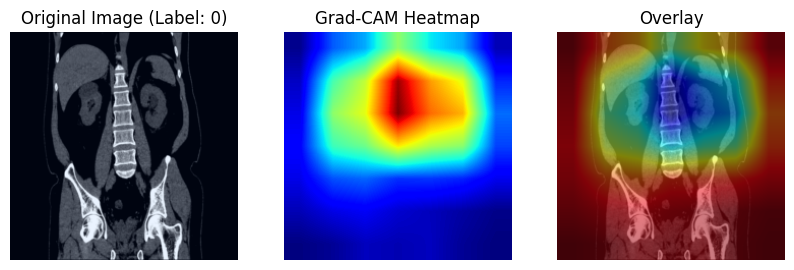

In [12]:
# Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None

        # Hook to capture feature maps
        self.target_layer.register_forward_hook(self.forward_hook)

    def forward_hook(self, module, input, output):
        self.feature_maps = output

    def generate_cam(self, input_tensor, class_idx):
        # Forward pass
        output = self.model(input_tensor)

        # Backward pass for the selected class
        self.model.zero_grad()
        one_hot = torch.zeros((1, output.size(-1)), dtype=torch.float32).to(input_tensor.device)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Calculate gradients manually
        gradients = torch.autograd.grad(outputs=output[:, class_idx],
                                         inputs=self.feature_maps,
                                         grad_outputs=torch.ones_like(output[:, class_idx]),
                                         retain_graph=True)[0]

        # Compute the Grad-CAM
        weights = gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.feature_maps).sum(dim=1).squeeze(0)

        # Normalize and resize CAM
        cam = torch.relu(cam).detach().cpu().numpy()  # Use detach() before numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam = cv2.resize(cam, (input_tensor.size(-1), input_tensor.size(-2)))

        return cam

# Select the target layer for Grad-CAM
target_layer = model.densenet.features[-1]  # Final convolutional layer
grad_cam = GradCAM(model, target_layer)

# Grad-CAM Visualization Function
def visualize_grad_cam(input_tensor, label, class_idx):
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension
    cam = grad_cam.generate_cam(input_tensor, class_idx)

    # Convert tensor to image
    input_image = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    input_image = np.uint8(255 * input_image)

    # Overlay heatmap on image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(input_image, 0.5, heatmap, 0.5, 0)

    # Display the original image, heatmap, and overlay
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title(f"Original Image (Label: {label})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()

# Example usage for Grad-CAM visualization
sample_data, sample_label = next(iter(val_loader))  # Take one batch
sample_data, sample_label = sample_data[0], sample_label[0]  # Take the first sample
predicted_class = model(sample_data.unsqueeze(0).to(device)).argmax(dim=1).item()

visualize_grad_cam(sample_data, sample_label.item(), predicted_class)


<ipython-input-21-e8e119174b1f>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("densenet.pt", map_location=device))


Predicted Class: Tumor


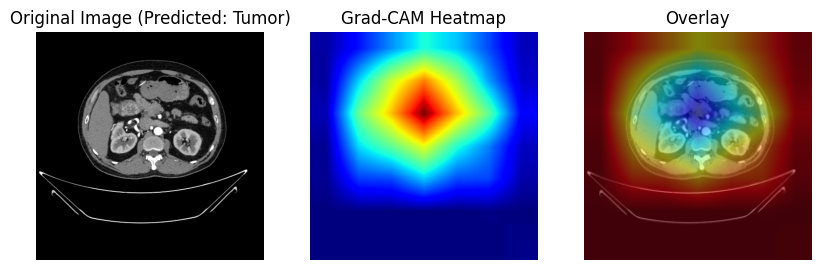

In [21]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define the DenseNet model
class DenseNetModel(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetModel, self).__init__()
        self.densenet = models.densenet121(pretrained=False)  # Ensure pretrained=False when loading a saved model
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.densenet(x)

# Initialize model and load weights
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DenseNetModel(num_classes=4).to(device)
model.load_state_dict(torch.load("densenet.pt", map_location=device))
model.eval()

# Define class names
class_names = ['Cyst', 'Normal', 'Stone', 'Tumor']  # Replace with your actual class names

# Define image transformation
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None

        # Hook to capture feature maps
        self.target_layer.register_forward_hook(self.forward_hook)

    def forward_hook(self, module, input, output):
        self.feature_maps = output

    def generate_cam(self, input_tensor, class_idx):
        # Forward pass
        output = self.model(input_tensor)

        # Backward pass for the selected class
        self.model.zero_grad()
        one_hot = torch.zeros((1, output.size(-1)), dtype=torch.float32).to(input_tensor.device)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Calculate gradients manually
        gradients = torch.autograd.grad(outputs=output[:, class_idx],
                                         inputs=self.feature_maps,
                                         grad_outputs=torch.ones_like(output[:, class_idx]),
                                         retain_graph=True)[0]

        # Compute the Grad-CAM
        weights = gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.feature_maps).sum(dim=1).squeeze(0)

        # Normalize and resize CAM
        cam = torch.relu(cam).detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam = cv2.resize(cam, (input_tensor.size(-1), input_tensor.size(-2)))

        return cam

# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = image_transform(image).unsqueeze(0).to(device)
    return input_tensor, image

# Image path (update with the path to your test image)
image_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (10).jpg"

# Load the image
input_tensor, original_image = load_image(image_path)

# Predict the class
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()
predicted_class_name = class_names[predicted_class]
print(f"Predicted Class: {predicted_class_name}")

# Grad-CAM visualization
target_layer = model.densenet.features[-1]  # Final convolutional layer
grad_cam = GradCAM(model, target_layer)
cam = grad_cam.generate_cam(input_tensor, predicted_class)

# Convert input tensor to numpy image
input_image = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
input_image = np.uint8(255 * input_image)

# Overlay Grad-CAM heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(input_image, 0.5, heatmap, 0.5, 0)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title(f"Original Image (Predicted: {predicted_class_name})")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


In [ ]:
jnkjnhk nvkjh vhnv fth ygyvgh gyyh